In [57]:
import pandas as pd
import xlrd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

## Load and Clean Dataset

In [58]:
file = 'CaseStudy2data.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Load a sheet into a DataFrame by name: df1
unchanged_attrition_df = xl.parse('HR-employee-attrition Data')
attrition_df = unchanged_attrition_df

#drop unneccessary columns with constant values
attrition_column = attrition_df["Attrition"]
attrition_df.drop("Attrition", axis=1, inplace=True)
attrition_df.insert(0, "Attrition", attrition_column)
attrition_df.drop('EmployeeCount', axis=1, inplace=True)
attrition_df.drop('StandardHours', axis=1, inplace=True)
attrition_df.drop('Over18', axis=1, inplace=True)

#convert attrition variable to binary
attrition_df = attrition_df.replace("Yes", 1)
attrition_df = attrition_df.replace("No", 0)

# code dummy variables, this is necessary to use sklearn
attrition_df = pd.get_dummies(attrition_df, columns=["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus"], prefix=["BusinessTravel", "Department", "EduationField", "Gender", "JobRole", "MaritalStatus"])
df_without_attrition = attrition_df.drop("Attrition", axis=1)
columns_without_attrition = df_without_attrition.columns
columns_with_attrition = attrition_df.columns
attrition_df

Attrition  Age  DailyRate  DistanceFromHome  Education  EmployeeNumber  \
0             1   41       1102                 1          2               1   
1             0   49        279                 8          1               2   
2             1   37       1373                 2          2               4   
3             0   33       1392                 3          4               5   
4             0   27        591                 2          1               7   
5             0   32       1005                 2          2               8   
6             0   59       1324                 3          3              10   
7             0   30       1358                24          1              11   
8             0   38        216                23          3              12   
9             0   36       1299                27          3              13   
10            0   35        809                16          3              14   
11            0   29        153                15          2              15   
12            0   31        670                26          1              16   
13            0   34       1346                19          2              18   
14            1   28        103                24          3              19   
15            0   29       1389                21          4              20   
16            0   32        334                 5          2              21   
17            0   22       1123                16          2              22   
18            0   53       1219                 2          4              23   
19            0   38        371                 2          3              24   
20            0   24        673                11          2              26   
21            1   36       1218                 9          4              27   
22            0   34        419                 7          4              28   
23            0   21        391                15          2              30   
24            1   34        699                 6          1              31   
25            0   53       1282                 5          3              32   
26            1   32       1125                16          1              33   
27            0   42        691                 8          4              35   
28            0   44        477                 7          4              36   
29            0   46        705                 2          4              38   
30            0   33        924                 2          3              39   
31            0   44       1459                10          4              40   
32            0   30        125                 9          2              41   
33            1   39        895                 5          3              42   
34            1   24        813                 1          3              45   
35            0   43       1273                 2          2              46   
36            1   50        869                 3          2              47   
37            0   35        890                 2          3              49   
38            0   36        852                 5          4              51   
39            0   33       1141                 1          3              52   
40            0   35        464                 4          2              53   
41            0   27       1240                 2          4              54   
42            1   26       1357                25          3              55   
43            0   27        994                 8          3              56   
44            0   30        721                 1          2              57   
45            1   41       1360                12          3              58   
46            0   34       1065                23          4              60   
47            0   37        408                19          2              61   
48            0   46       1211                 5          4              62   
49    

## Split into Train and Test Set

In [59]:
rand = np.random.rand(len(attrition_df)) < 0.8

train = attrition_df[rand]
test = attrition_df[~rand]

print(train.shape)
print(test.shape)

(1200, 52)
(270, 52)


## Correlation Matrix to Identify Covariance

In [60]:
train.corr().abs()

Attrition       Age  DailyRate  \
Attrition                           1.000000  0.165084   0.066143   
Age                                 0.165084  1.000000   0.006940   
DailyRate                           0.066143  0.006940   1.000000   
DistanceFromHome                    0.074324  0.014687   0.001565   
Education                           0.043821  0.192692   0.038819   
EmployeeNumber                      0.019925  0.000461   0.081551   
EnvironmentSatisfaction             0.115188  0.014982   0.062648   
HourlyRate                          0.020474  0.020105   0.000060   
JobInvolvement                      0.117189  0.018700   0.045088   
JobLevel                            0.175375  0.502994   0.012358   
JobSatisfaction                     0.111232  0.002296   0.045761   
MonthlyIncome                       0.164152  0.489809   0.011883   
MonthlyRate                         0.005402  0.033747   0.054695   
NumCompaniesWorked                  0.029966  0.291960   0.038554   
OverTime                            0.253465  0.030497   0.021358   
PercentSalaryHike                   0.017377  0.001130   0.021484   
PerformanceRating                   0.004762  0.001368   0.000073   
RelationshipSatisfaction            0.041383  0.058382   0.005319   
StockOptionLevel                    0.152710  0.048207   0.034407   
TotalWorkingYears                   0.186377  0.679597   0.010255   
TrainingTimesLastYear               0.050527  0.025184   0.002472   
WorkLifeBalance                     0.074270  0.036342   0.050448   
YearsAtCompany                      0.134755  0.327667   0.051703   
YearsInCurrentRole                  0.152047  0.234054   0.017518   
YearsSinceLastPromotion             0.027352  0.223083   0.056916   
YearsWithCurrManager                0.155333  0.211201   0.045487   
BusinessTravel_Non-Travel           0.093783  0.000367   0.002777   
BusinessTravel_Travel_Frequently    0.118675  0.031801   0.000996   
BusinessTravel_Travel_Rarely        0.038155  0.027514   0.001029   
Department_Human Resources          0.028903  0.013472   0.010576   
Department_Research & Development   0.099386  0.019747   0.005214   
Department_Sales                    0.090228  0.026175   0.000845   
EduationField_Human Resources       0.036625  0.012165   0.022009   
EduationField_Life Sciences         0.051581  0.020448   0.011894   
EduationField_Marketing             0.063176  0.041534   0.060155   
EduationField_Medical               0.043174  0.000680   0.024453   
EduationField_Other                 0.017514  0.034137   0.014871   
EduationField_Technical Degree      0.086808  0.045463   0.027526   
Gender_Female                       0.007859  0.029173   0.032953   
Gender_Male                         0.007859  0.029173   0.032953   
JobRole_Healthcare Representative   0.076694  0.119658   0.046559   
JobRole_Human Resources             0.048195  0.039177   0.018967   
JobRole_Laboratory Technician       0.102020  0.140848   0.018611   
JobRole_Manager                     0.090251  0.292560   0.002851   
JobRole_Manufacturing Director      0.086395  0.045697   0.009526   
JobRole_Research Director           0.085231  0.149345   0.030994   
JobRole_Research Scientist          0.013942  0.146265   0.006971   
JobRole_Sales Executive             0.014952  0.003016   0.000176   
JobRole_Sales Representative        0.176200  0.164158   0.013069   
MaritalStatus_Divorced              0.086526  0.027763   0.038968   
MaritalStatus_Married               0.110463  0.100486   0.033603   
MaritalStatus_Single                0.194623  0.131591   0.070488   

                                   DistanceFromHome  Education  \
Attrition                                  0.074324   0.043821   
Age                                        0.014687   0.192692   
DailyRate                                  0.001565   0.038819   
DistanceFromHome                           1.000000   0.039836   
Education                                  0.03

Based off looking at the correlation matrix above, there are not any values that stand out as extremly correlated (0.8). Thus no variables will be removed.

## Recursive Feature Elimination

In [61]:
np.set_printoptions(precision=3)

values = train.values

X = values[:,1:(len(train.columns))]
Y = values[:,0]

test_values = test.values
X_test = test_values[:,1:(len(test.columns))]
Y_test = test_values[:,0]


number_of_features_to_select = 5
# feature extraction
model = LogisticRegression()
rfe = RFE(model, number_of_features_to_select)
fit = rfe.fit(X, Y)
print(fit.support_)
print(fit.ranking_)
true_indexes = [i for i, x in enumerate(fit.support_) if x == True]
features = np.asarray(columns_without_attrition[true_indexes])
print(features)

predictions = rfe.predict(X_test)
print('Accuracy of RFE on test set: {:.5f}'.format(fit.score(X_test, Y_test)))


[False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True  True  True False False  True
 False False False]
[40 44 38 39 46 12 43 10 37 13 45 47 27  1 36 35 20 18 29 23 15 33 32 26
 25  2  8 17 21 24 14  9 30 11 31 28  5 19 16  4  6  7  1  1  1 42 41  1
 34 22  3]
['OverTime' 'JobRole_Manager' 'JobRole_Manufacturing Director'
 'JobRole_Research Director' 'JobRole_Sales Representative']
Accuracy of RFE on test set: 0.88148


## Feature Importance With ExtraTreesClassifier

In [62]:
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
model = ExtraTreesClassifier()
fit = model.fit(X, Y)

importances = model.feature_importances_
print(importances)

idxs = np.argsort(importances)[-(number_of_features_to_select):]
features = np.asarray(columns_without_attrition[idxs])
print(list(reversed(features.tolist())))

predictions = model.predict(X_test)
print('Accuracy of extra trees classifier on test set: {:.5f}'.format(model.score(X_test, Y_test)))


[0.037 0.023 0.03  0.024 0.029 0.035 0.025 0.026 0.029 0.03  0.035 0.019
 0.028 0.07  0.023 0.014 0.028 0.023 0.04  0.022 0.024 0.029 0.024 0.025
 0.022 0.006 0.018 0.007 0.005 0.015 0.009 0.003 0.016 0.012 0.017 0.003
 0.013 0.015 0.017 0.007 0.005 0.018 0.005 0.005 0.002 0.009 0.007 0.019
 0.012 0.012 0.03 ]
['OverTime', 'TotalWorkingYears', 'Age', 'MonthlyIncome', 'EnvironmentSatisfaction']
Accuracy of extra trees classifier on test set: 0.87407


## Random Forrest

In [63]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X, Y)

clf.predict(X_test)

# preds = iris.target_names[clf.predict(test[features])]
train.describe()
test.describe()
preds = clf.predict_proba(X_test)

predictions = []
attrition_count = 0
not_attrition_count = 0
for pred in preds:
    if pred[0] >= pred[1]:
        not_attrition_count = not_attrition_count + 1
        predictions.append('No Attrition') 
    else:
        attrition_count = attrition_count + 1
        predictions.append('Attrition')
    
print("Attrition count: ")
print(attrition_count)
print("Not Attrition count: ")
print(not_attrition_count)
print('Accuracy of random forrest on test set: {:.5f}'.format(clf.score(X_test, Y_test)))
print(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), columns_without_attrition), reverse=True)[:5])



Attrition count: 
8
Not Attrition count: 
262
Accuracy of random forrest on test set: 0.87778
[(0.0638, 'MonthlyIncome'), (0.0614, 'Age'), (0.054, 'OverTime'), (0.0476, 'DailyRate'), (0.0442, 'EmployeeNumber')]


## Logistic Regression

In [64]:
logreg = LogisticRegression()
logreg.fit(X, Y)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, Y_test)))


Accuracy of logistic regression classifier on test set: 0.90000


In [65]:
denom = (2.0*(1.0+np.cosh(logreg.decision_function(X))))
F_ij = np.dot((X/denom[:,None]).T,X) ## Fisher Information Matrix
Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
z_scores = logreg.coef_[0]/sigma_estimates # z-score for eaach model coefficient
p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values

print(sorted(list(zip(p_values, columns_without_attrition)))[:5])

[(2.975776130028761e-06, 'OverTime'), (2.619262181521254e-05, 'NumCompaniesWorked'), (0.00013052188090593346, 'DistanceFromHome'), (0.0004482246694927526, 'YearsSinceLastPromotion'), (0.0005078865575950501, 'EnvironmentSatisfaction')]


## Data Exploration

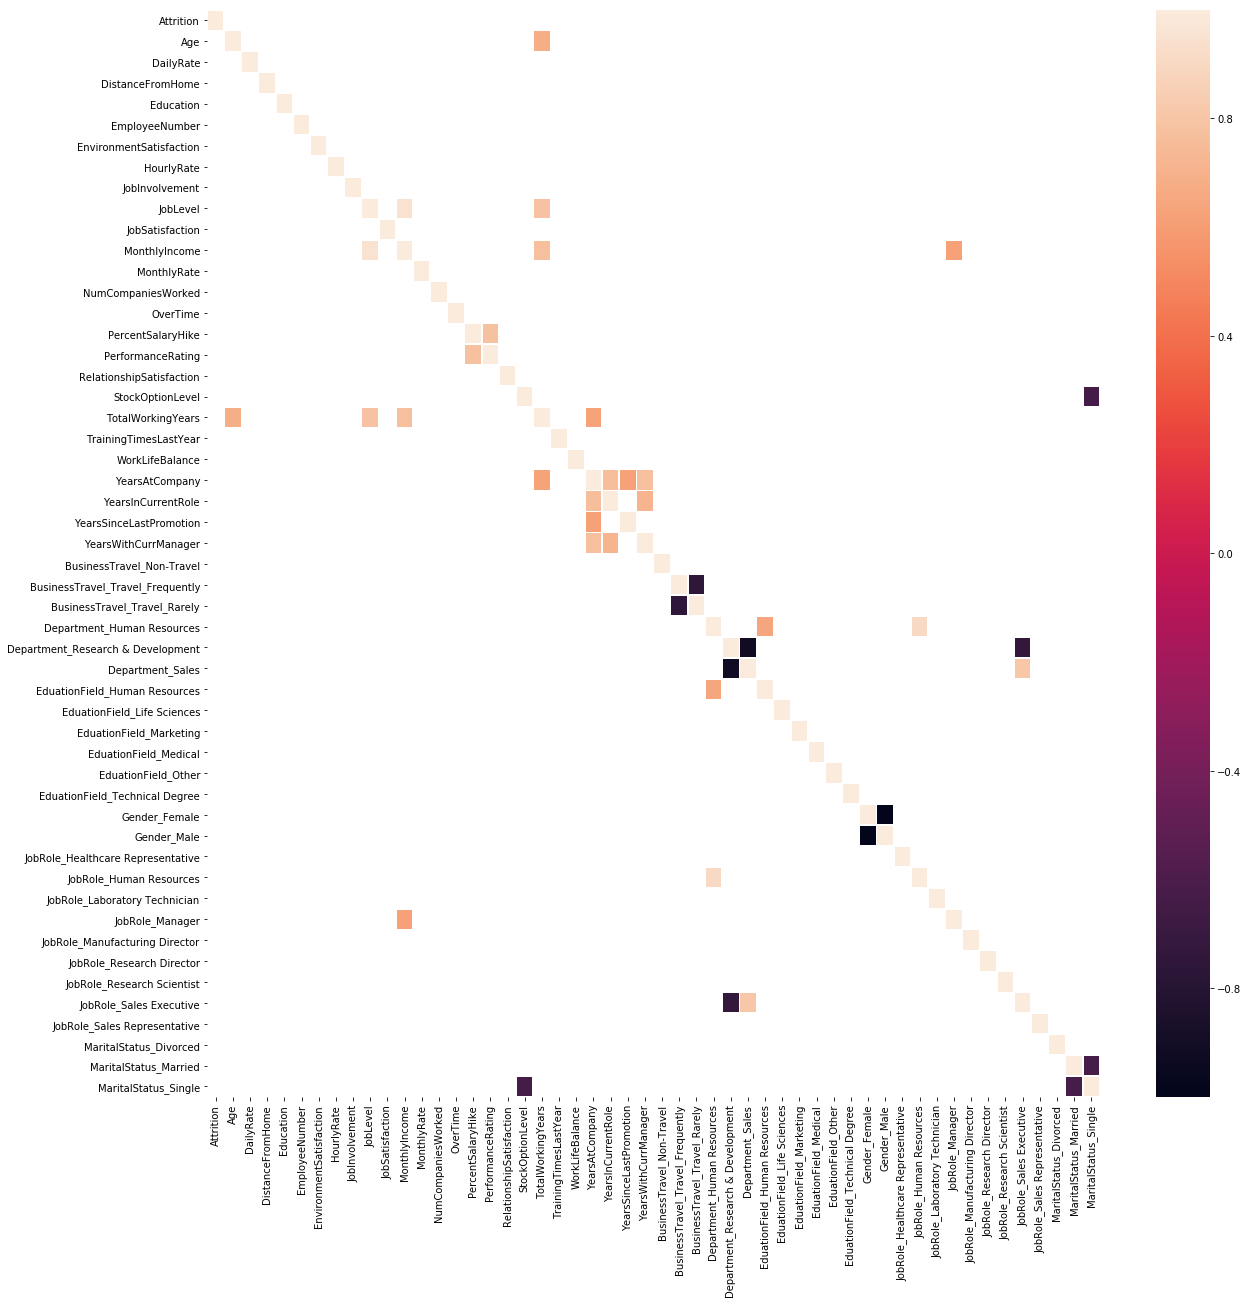

In [66]:
plt.figure(figsize = (20,20))
corr = attrition_df.corr()
sns.heatmap(corr[(corr >= 0.6) | (corr <= -0.6)], 
        xticklabels=columns_with_attrition,
        yticklabels=columns_with_attrition, linewidths=.6)

There does not appear to be a high degree of correlation between different factor that warrant removal of certain factors. All factors will be left in for further analysis.

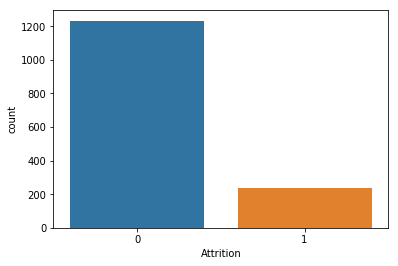

In [67]:
sns.countplot(x='Attrition',data=attrition_df)
plt.show()

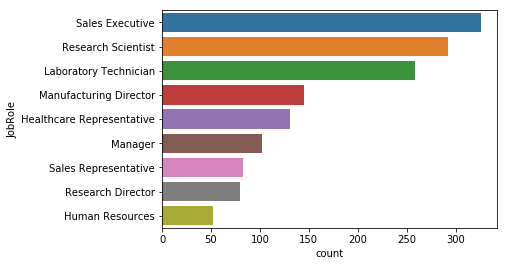

In [68]:
sns.countplot(y="JobRole", data=unchanged_attrition_df)
plt.show()

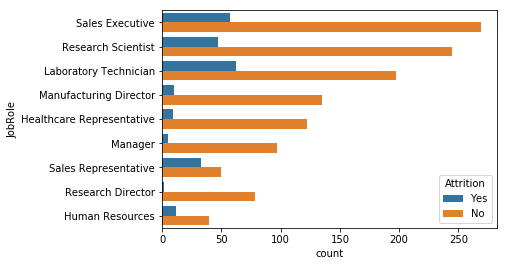

In [69]:
sns.countplot(y="JobRole", hue="Attrition", data=unchanged_attrition_df)

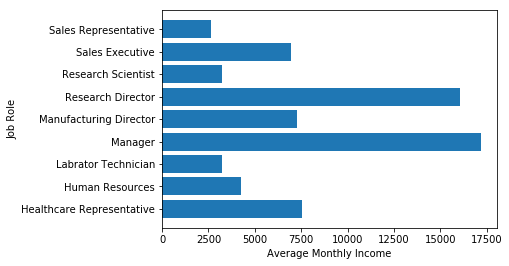

In [70]:
income = unchanged_attrition_df.groupby('JobRole').mean()[['MonthlyIncome']].values
flattened_income = []
for i in income:
    flattened_income.append(i[0])
    
roles = ['Healthcare Representative', 'Human Resources', 'Labrator Technician', 'Manager', 'Manufacturing Director', 'Research Director', 'Research Scientist' , 'Sales Executive','Sales Representative']

y_pos = np.arange(len(roles))

plt.xlabel('Average Monthly Income')
plt.ylabel('Job Role')
 
# Create horizontal bars
plt.barh(y_pos, flattened_income)
 
# Create names on the y-axis
plt.yticks(y_pos, roles)
 
# Show graphic
plt.show()



## Interesting Trends

We will looks at trends in job roles vs some of the factors that were selected in the different models.

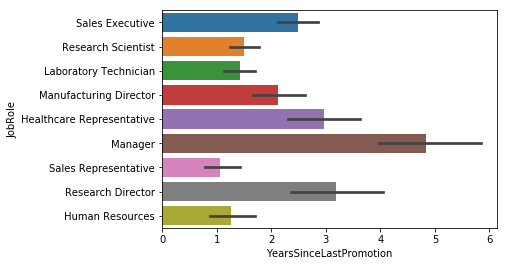

In [71]:
sns.barplot(x="YearsSinceLastPromotion", y="JobRole", data=unchanged_attrition_df)

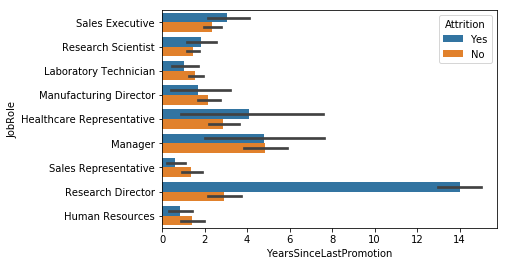

In [72]:
sns.barplot(x="YearsSinceLastPromotion", y="JobRole",hue= "Attrition", data=unchanged_attrition_df)

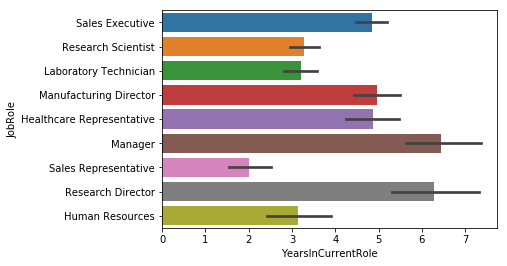

In [73]:
sns.barplot(x="YearsInCurrentRole", y="JobRole", data=unchanged_attrition_df)

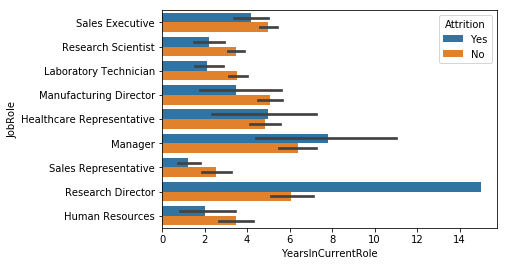

In [74]:
sns.barplot(x="YearsInCurrentRole", y="JobRole", hue= "Attrition", data=unchanged_attrition_df)

In [75]:
unchanged_attrition_df.corr()[["YearsSinceLastPromotion"]]["YearsInCurrentRole":"YearsInCurrentRole"]

YearsSinceLastPromotion
YearsInCurrentRole                 0.548056

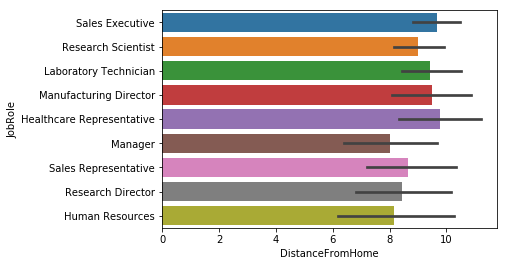

In [76]:
sns.barplot(x="DistanceFromHome", y="JobRole", data=unchanged_attrition_df)

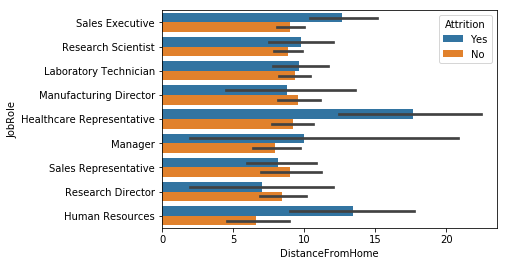

In [77]:
sns.barplot(x="DistanceFromHome", y="JobRole", hue= "Attrition", data=unchanged_attrition_df)

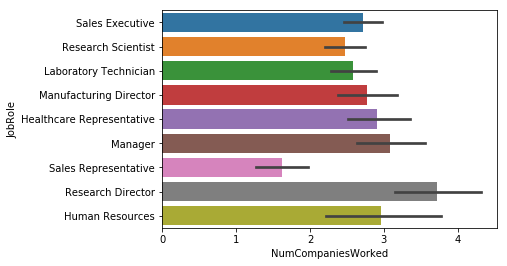

In [78]:
sns.barplot(x="NumCompaniesWorked", y="JobRole", data=unchanged_attrition_df)

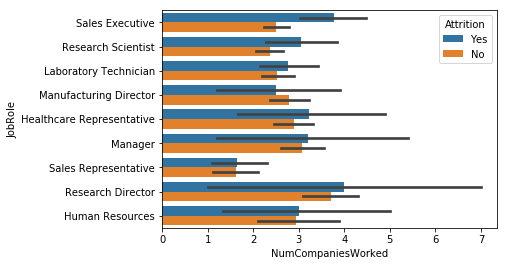

In [79]:
sns.barplot(x="NumCompaniesWorked", y="JobRole", hue="Attrition", data=unchanged_attrition_df)

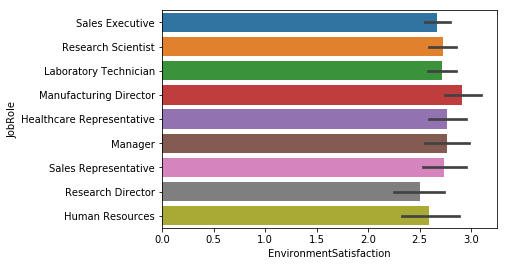

In [80]:
sns.barplot(x="EnvironmentSatisfaction", y="JobRole", data=unchanged_attrition_df)

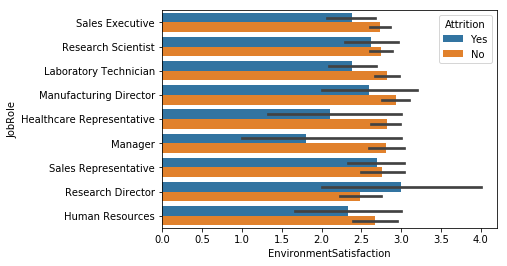

In [81]:
sns.barplot(x="EnvironmentSatisfaction", y="JobRole",hue= "Attrition", data=unchanged_attrition_df)

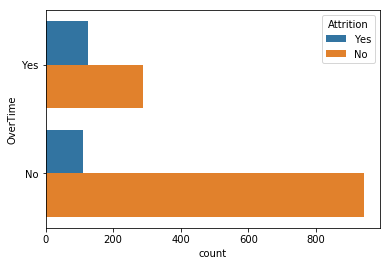

In [82]:
sns.countplot(y="OverTime", hue="Attrition", data=unchanged_attrition_df)

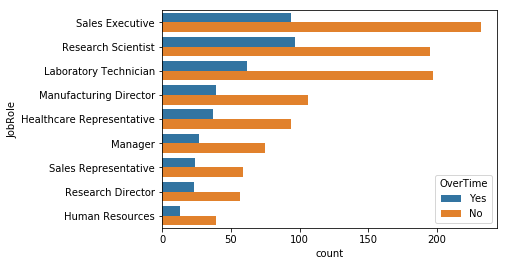

In [83]:
sns.countplot(y="JobRole", hue="OverTime", data=unchanged_attrition_df)

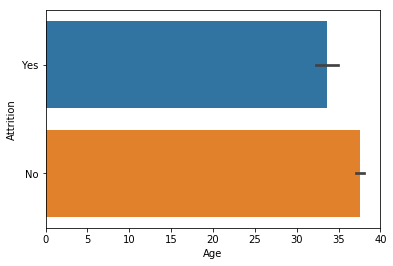

In [89]:
sns.barplot(x="Age", y="Attrition", data=unchanged_attrition_df)

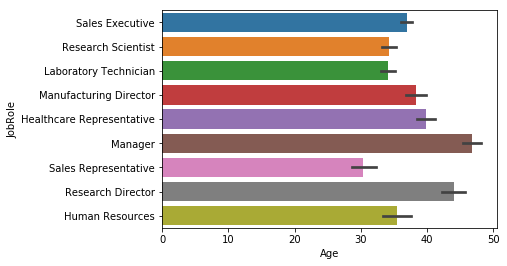

In [84]:
sns.barplot(x="Age", y="JobRole", data=unchanged_attrition_df)

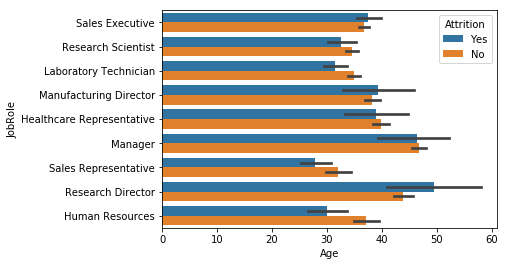

In [85]:
sns.barplot(x="Age", y="JobRole", hue="Attrition", data=unchanged_attrition_df)